<a href="https://colab.research.google.com/github/EighteenSprings/Pytorch_Tutorial/blob/main/WGAN_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

写完感觉自己训练有点问题，就是生成的动漫头像太单一了，准备参考下这个代码  
https://github.com/Lornatang/WassersteinGAN_GP-PyTorch/blob/master/trainer.py

Dataset(Google Drive): https://drive.google.com/file/d/1UKfH2KQl5Uj_qzKWAM3rmiQ3yMZZtOG6/view?usp=sharing

In [ ]:
# 装载 Google 硬盘，并将 二次元人脸 数据集压缩文件拷贝到当前目录
!cp /content/drive/MyDrive/GAN/Dataset/anime-faces.zip ./
!mkdir dataset
!unzip -q anime-faces.zip -d dataset

In [ ]:
import os
train_dir = os.path.join('dataset', 'data')
# val_dir = os.path.join('dataset', 'val')
# test_dir = os.path.join('dataset', 'test')

print(f'Number of training: {len(os.listdir(train_dir))}')
# print(f'Number of validation: {len(os.listdir(val_dir))}')
# print(f'Number of testing: {len(os.listdir(test_dir))}')

Number of training: 21552


In [ ]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

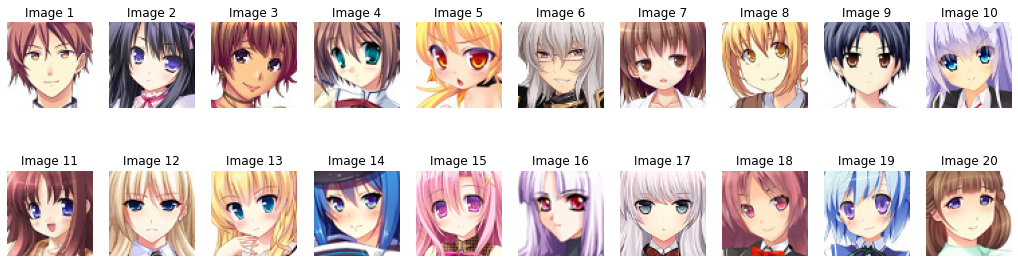

In [ ]:
im_lst = os.listdir(train_dir)
im_lst = [x for x in im_lst if x.endswith('png')]
fig = plt.figure(figsize=(18,5))
rows = 2
cols = 10
for i in range(1, 21):
    fig.add_subplot(rows, cols, i)
    im = plt.imread(os.path.join(train_dir, random.choice(im_lst)))
    plt.imshow(im)
    plt.axis('off')
    plt.title(f'Image {i}')

Text(0.5, 1.0, 'image shape: (64, 64, 3)')

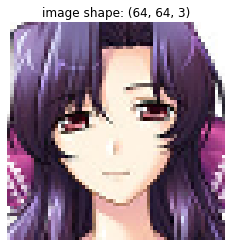

In [ ]:
import numpy as np
im = plt.imread(os.path.join(train_dir, random.choice(im_lst)))
plt.imshow(im)
plt.axis('off')
plt.title(f'image shape: {im.shape}')

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [ ]:
class AnimeFaceData(Dataset):
    def __init__(self, names_list, root_dir, transform=None):
        self.pth_list = [os.path.join(root_dir, x) for x in names_list]
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.pth_list)
    
    def __getitem__(self, idx):
        im = plt.imread(self.pth_list[idx])
        if self.transform:
            im = self.transform(im)
        return im,

In [ ]:
# test
af = AnimeFaceData(im_lst, train_dir)
test_data = af[10]

In [ ]:
from multiprocessing import cpu_count
print(f'CPU 核心数量: {cpu_count()}')

CPU 核心数量: 2


In [ ]:
af = AnimeFaceData(im_lst, train_dir, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))
AFDataLoader = DataLoader(dataset=af, batch_size=64, shuffle=True, num_workers=cpu_count())

In [ ]:
# test
test_data = next(iter(AFDataLoader))
test_data[0].shape

torch.Size([64, 3, 64, 64])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# hyper parmeters

# number of latent z
nz = 100
# nubmer of generator features
ngf = 64
# nubmer of discriminator features
ndf = 64
# number of channels for image
nc = 3
# number of gpus
# ngpu = 1
# image size
im_size = 64

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True)
        )
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True)
        )
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True)
        )
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True)
        )
        self.deconv5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv5(x)
        return x.view(-1, nc, im_size, im_size)

In [ ]:
print(Generator())

Generator(
  (deconv1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (deconv3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (deconv4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (deconv5): Sequential(
    (0): ConvT

In [ ]:
!pip install torch-summary

In [ ]:
from torchsummary import summary
summary(Generator(), (100,1,1))
print()

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
├─Sequential: 1-2                        [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,408
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
├─Sequential: 1-3                        [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
├─Sequential: 1-4                        [-1, 64, 32, 32]      

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [ ]:
netG = Generator()
netG.apply(weights_init)
print()

In [ ]:
# test
test_in = torch.rand((1,3,64,64))
test_out = nn.Conv2d(3, 3, 4, 2, 1)(test_in)
print(test_out.shape)

torch.Size([1, 3, 32, 32])


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 4, 1, 0)
        )

    def forward(self, x):
        x = self.main(x)
        return x.view(-1,1).squeeze(1)

In [ ]:
summary(Discriminator(), (3, 64, 64))
print()

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─BatchNorm2d: 2-2                  [-1, 64, 32, 32]          128
|    └─LeakyReLU: 2-3                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-4                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-5                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-6                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-7                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-8                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-9                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-10                      [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-11                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-12                   [-1, 512, 4, 4]   

In [ ]:
# test
test_in = torch.rand((1,3, 64, 64))
test_out = Discriminator()(test_in)
print(test_out.shape)

torch.Size([1])


In [ ]:
netD = Discriminator()
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=(

In [ ]:
# batch_size = 64
batchSize = 64

criterion = nn.BCELoss()

fixed_noise = torch.randn(batchSize, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

In [ ]:
lr = 0.0002
beta1 = 0.5

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
def calc_gradient_penalty(netD, real_data, fake_data):
    batch_size = real_data.shape[0]
    alpha = torch.rand((batch_size, 1, 1, 1))
    alpha = alpha.to(device)

    interpolates = alpha*real_data + (1. - alpha)*fake_data
    
    interpolates = torch.autograd.Variable(interpolates, requires_grad=True)
    # interpolates = interpolates.to(device)

    disc_discriminator = netD(interpolates)
    gradients = torch.autograd.grad(
        outputs=disc_discriminator,
        inputs=interpolates,
        grad_outputs=torch.ones_like(disc_discriminator),
        retain_graph=True,
        create_graph=True,
        only_inputs=True
    )[0]
    gradients_penalty = ((gradients.norm(2, dim=1) - 1)**2).mean()
    return gradients_penalty

In [ ]:
!rm -rf models

In [ ]:
import torchvision.utils as vutils

Epoches = 50

outf = 'models'
real_label = 1
fake_label = 0

try:
    os.mkdir(outf)
except OSError:
    pass

errD_lst = []
errG_lst = []



# initialize
# netG = Generator()
# netG.to(device)
# netG.apply(weights_init)
# netD = Discriminator()
# netD.to(device)
# netD.apply(weights_init)

# criteion
lr = 0.0002
beta1 = 0.5

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))



for epoch in range(1, Epoches+1):
    for i,data in enumerate(AFDataLoader):
        # print(data[0].shape)
        #######################
        # update generator #
        #######################
        netD.zero_grad()
        real = data[0].to(device)
        batch_size = data[0].size(0)
        #label = torch.full((batch_size,), real_label, dtype=real.dtype, device=device)

        noise = torch.rand((batch_size,nz,1,1))
        noise = noise.to(device)
        fake = netG(noise)


        loss_real = -1.*netD(real).mean()
        loss_fake = netD(fake.detach()).mean()
        loss_penalty = calc_gradient_penalty(netD, real, fake)
        loss_all = loss_real + loss_fake + loss_penalty*10
        
        loss_all.backward()
        optimizerD.step()
        
        loss_G = 0.0
        for _ in range(4):
            # train generator 4 times
            netG.zero_grad()
            noise = torch.rand((batch_size, nz, 1, 1))
            noise = noise.to(device)
            fake = netG(noise)
            loss_g = -1.*netD(fake).mean()
            loss_G += loss_g.cpu().detach().item()
            loss_g.backward()

            optimizerG.step()
        if i%10==0:
            print(f'Epoch:[{epoch}/{Epoches}], Iteration:[{i+1}/{len(af)}], loss_D:{loss_all.cpu().detach()}, loss_G: {loss_G/4}')
        if i%100 == 0:
            with torch.no_grad():
                noise = torch.rand((batch_size, nz, 1, 1)).to(device)
                gen_im = netG(noise)
                out_img = vutils.make_grid(gen_im, normalize=True)            
                vutils.save_image(out_img, f'{outf}/epoch_{epoch}_image_{i}.png')

Epoch:[1/50], Iteration:[1/21551], loss_D:11.821053504943848, loss_G: -24.52185344696045
Epoch:[1/50], Iteration:[11/21551], loss_D:13.501144409179688, loss_G: -17.312944412231445
Epoch:[1/50], Iteration:[21/21551], loss_D:12.72819709777832, loss_G: -18.750021934509277
Epoch:[1/50], Iteration:[31/21551], loss_D:11.388833045959473, loss_G: -12.78003716468811
Epoch:[1/50], Iteration:[41/21551], loss_D:11.944022178649902, loss_G: -12.516320705413818
Epoch:[1/50], Iteration:[51/21551], loss_D:11.174647331237793, loss_G: -10.957997798919678
Epoch:[1/50], Iteration:[61/21551], loss_D:11.221301078796387, loss_G: -9.621900081634521
Epoch:[1/50], Iteration:[71/21551], loss_D:11.538076400756836, loss_G: -9.096867561340332
Epoch:[1/50], Iteration:[81/21551], loss_D:10.400496482849121, loss_G: -8.087425708770752
Epoch:[1/50], Iteration:[91/21551], loss_D:11.253499031066895, loss_G: -8.389180660247803
Epoch:[1/50], Iteration:[101/21551], loss_D:10.907371520996094, loss_G: -7.006358623504639
Epoch:[

In [ ]:
!tar cf anima_face_wgangp.tar models
!tar zcf anima_face_wgangp.tar.gz anima_face_wgangp.tar
!cp anima_face_wgangp.tar.gz /content/drive/MyDrive/GAN/WGAN-GP

In [ ]:
torch.save(netG.state_dict(), 'anima_face_wgan_netG.pth')

In [ ]:
!cp anima_face_wgan_netG.pth /content/drive/MyDrive/GAN/WGAN-GP